In [85]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.exceptions import ConvergenceWarning

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning) 

start = time.perf_counter()

In [86]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               907 non-null    object 
 1   SeasonNumber       907 non-null    int64  
 2   SeasonVersion      907 non-null    int64  
 3   Player             907 non-null    object 
 4   MatchId            907 non-null    object 
 5   Map                907 non-null    object 
 6   Category           907 non-null    object 
 7   Playlist           907 non-null    object 
 8   Input              907 non-null    object 
 9   Queue              907 non-null    object 
 10  PreCsr             907 non-null    int64  
 11  PostCsr            907 non-null    int64  
 12  Rank               907 non-null    int64  
 13  WasAtStart         907 non-null    int64  
 14  WasAtEnd           907 non-null    int64  
 15  WasInProgressJoin  907 non-null    int64  
 16  Mmr                2 non-n

In [87]:
# General Fixes+Additions
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
# Ratios
df['DamageRatio'] = df['DamageDone'].replace(0, 1) / df['DamageTaken'].replace(0, 1)
df['Damage/Kill'] = df['DamageDone'] / df['Kills']
df['Damage/KA'] = df['DamageDone'] / (df['Kills'] + df['Assists'])
# Per 10 Min
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['Shots/10Min'] = (df['ShotsFired'] / df['LengthMinutes']) * 10
# Excess
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
# Kill Type
df['BodyPct'] = df['KillsBody'] / df['Kills'] *100
df['MeleePct'] = df['KillsMelee'] / df['Kills'] * 100
df['HSPct'] = df['KillsHeadshot'] / df['Kills'] * 100
df['GrenadePct'] = df['KillsGrenade'] / df['Kills'] * 100
df['PowerPct'] = df['KillsPower'] / df['Kills'] * 100



df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'PreCsr', 'PostCsr', 'ShotsFired', 'AssistsEmp',
              'ShotsMissed', 'ShotsLanded', 'Betrayals', 'Suicides', 'WasAtStart', 'WasAtEnd', 'AssistsDriver',
              'Perfects', 'WasInProgressJoin', 'VehicleDestroys', 'VehicleHijacks', 'AssistsCallout',
              'LengthSeconds', 'Rank', 'SeasonNumber', 'SeasonVersion', 'Map'],axis=1)
df = df.drop(['KillsBody','KillsMelee', 'KillsGrenade', 'KillsHeadshot', 'KillsPower'], axis=1)
# df = df.drop(['Kills','Deaths', 'Assists', 'DamageDone', 'DamageTaken'], axis=1)
dfR = df[df['Playlist'] == 'Ranked Arena']
dfRR = dfR[dfR['Date']> '2023-01-01']
dfRR = dfRR[dfRR['Outcome'] != 'Draw']
dfRR = dfRR[dfRR['Outcome'] != 'Left']
dfRR['Outcome'] = dfRR['Outcome'].map({'Win': 1, 'Loss': 0})
dfRR = dfRR.drop(['Date', 'Category', 'Playlist'], axis=1)
dfRR = dfRR.dropna()
dfRR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 140 to 906
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Outcome         641 non-null    int64  
 1   Accuracy        641 non-null    float64
 2   DamageDone      641 non-null    int64  
 3   DamageTaken     641 non-null    int64  
 4   KD              641 non-null    float64
 5   KDA             641 non-null    float64
 6   Kills           641 non-null    int64  
 7   Deaths          641 non-null    int64  
 8   Assists         641 non-null    int64  
 9   MaxSpree        641 non-null    int64  
 10  ExpectedKills   641 non-null    float64
 11  ExpectedDeaths  641 non-null    float64
 12  Score           641 non-null    int64  
 13  Medals          641 non-null    int64  
 14  LengthMinutes   641 non-null    float64
 15  DamageRatio     641 non-null    float64
 16  Damage/Kill     641 non-null    float64
 17  Damage/KA       641 non-null    f

In [88]:
corr_mtrx = dfRR.corr().abs()
print(corr_mtrx['Outcome'].sort_values(ascending=False))

Outcome           1.000000
Deaths/10Min      0.435669
DmgT/10Min        0.363587
KD                0.315215
Deaths            0.310228
KDA               0.287857
Damage/KA         0.283305
ExcessDeaths      0.262835
DamageTaken       0.245927
ExpectedDeaths    0.200323
Assists/10Min     0.187368
Damage/Kill       0.181400
Kills/10Min       0.143790
LengthMinutes     0.128163
Accuracy          0.119955
MaxSpree          0.107928
DamageDone        0.081156
Assists           0.070419
Score             0.044598
Dmg/10Min         0.041539
DamageRatio       0.039758
BodyPct           0.035852
HSPct             0.030159
MeleePct          0.025836
ExpectedKills     0.024687
Medals            0.021401
GrenadePct        0.015889
Kills             0.012806
ExcessKills       0.007517
PowerPct          0.007060
Shots/10Min       0.002837
Name: Outcome, dtype: float64


In [89]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [90]:
# Define features (X) and target variable (y)
X = dfRR.drop('Outcome', axis=1) 
X = round(X,20)
y = dfRR['Outcome'] 

print(f'X Shape: {X.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (641, 30)
Y Shape: (641,)


In [108]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=6)
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')
# print(X_train.columns)
print(f'Y Train Mean: {round(y_train.mean(),3)}')
print(f'Y Test Mean: {round(y_test.mean(),3)}')

X Train Shape: (512, 30)
X Test Shape: (129, 30)
Y Train Mean: 0.547
Y Test Mean: 0.574


In [109]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Accuracy', 'ExpectedKills', 'ExpectedDeaths', 'KD', 
                                    'KDA', 'MaxSpree', 'Deaths', 'Assists', 'Kills', 'DamageDone', 
                                    'DamageTaken', 'Score', 'Medals', 'LengthMinutes', 
                                    'DamageRatio', 'Damage/Kill', 'Damage/KA', 
                                    'Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min',
                                    'DmgT/10Min', 'Shots/10Min', 'ExcessKills', 'ExcessDeaths',
                                    'BodyPct', 'MeleePct', 'HSPct', 'GrenadePct', 'PowerPct'])])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_pp = pipeline.fit_transform(X_train)
X_test_pp = pipeline.transform(X_test)

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train_pp, X_val_pp, y_train, y_val = train_test_split(X_train_pp, y_train, test_size=0.2, random_state=21)

# X_train_preprocessed.to_csv('X_train_preprocessed.csv')
# X_test_preprocessed.to_csv('X_test_preprocessed.csv')
print(f'X Train Processed Shape: {X_train_pp.shape}')
print(f'X Val Processed Shape: {X_val_pp.shape}')
print(f'X Test Processed Shape: {X_test_pp.shape}')
print(f'Y Train Shape: {y_train.shape}')
print(f'Y Val Shape: {y_val.shape}')
print(f'Y Test Shape: {y_test.shape}')

X Train Processed Shape: (409, 30)
X Val Processed Shape: (103, 30)
X Test Processed Shape: (129, 30)
Y Train Shape: (409,)
Y Val Shape: (103,)
Y Test Shape: (129,)


In [93]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {
    'activation': ['logistic', 'tanh', 'relu', 'identity'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.001, 0.01, 0.1, 1],
    'learning_rate': ['constant', 'adaptive']
}

# Perform grid search
grid_search = GridSearchCV(MLPClassifier(random_state=27), param_grid, cv=5)
grid_search.fit(X_train_pp, y_train)

# Get the best parameters and model
best_mlp = grid_search.best_estimator_
best_mlp_stats = {
    'Training Accuracy': best_mlp.score(X_train_pp, y_train),
    'Validation Accuracy': best_mlp.score(X_val_pp, y_val),
    'Test Accuracy': best_mlp.score(X_test_pp, y_test)
}
print(best_mlp_stats)
print(best_mlp)

{'Training Accuracy': 0.8312958435207825, 'Validation Accuracy': 0.7572815533980582, 'Test Accuracy': 0.7596899224806202}
MLPClassifier(activation='tanh', alpha=0.1, random_state=27)


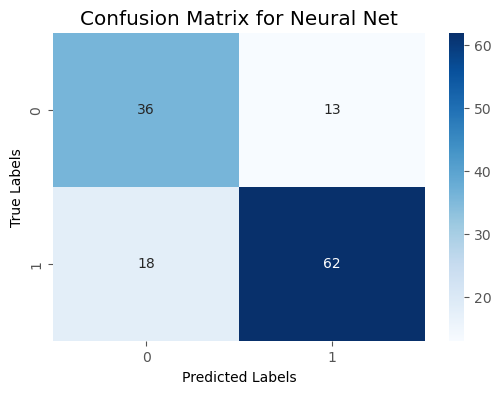

The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.


<Axes: >

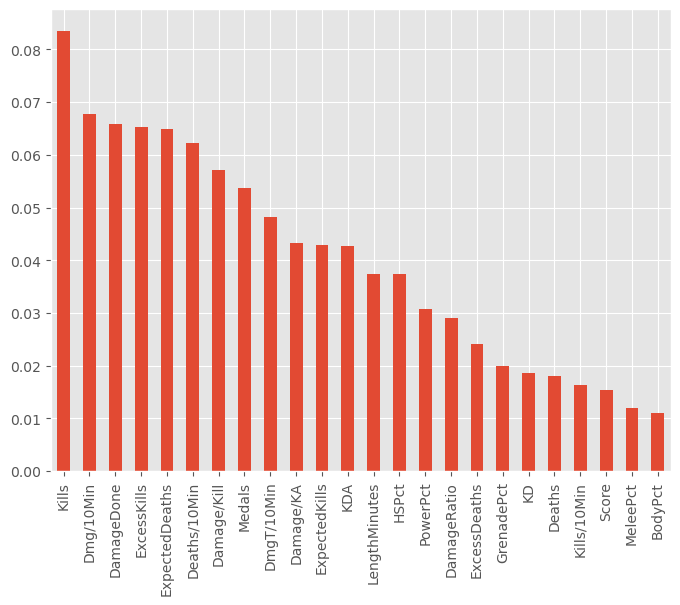

In [94]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix for the Neural Net
conf_matrix = confusion_matrix(y_test, best_mlp.predict(X_test_pp))
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Neural Net')
plt.show()

print("The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.")
feat_importances_mlpc = pd.DataFrame(best_mlp.coefs_[0].flatten()[:30], index=X_train.columns, columns=["Importance"])
feat_importances_mlpc = feat_importances_mlpc.abs().sum(axis=1)
feat_importances_mlpc = feat_importances_mlpc / feat_importances_mlpc.sum()
feat_importances_mlpc = feat_importances_mlpc.sort_values(ascending=False)[:24]
feat_importances_mlpc.plot(kind='bar', figsize=(8,6))

## Torch Simple Neural Net

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

y_train_array = y_train.values
y_val_array = y_val.values

# Then create tensors from the NumPy arrays
X_train_pp_tensor = torch.tensor(X_train_pp, dtype=torch.float)
y_train_tensor = torch.tensor(y_train_array, dtype=torch.long)
X_val_pp_tensor = torch.tensor(X_val_pp, dtype=torch.float)
y_val_tensor = torch.tensor(y_val_array, dtype=torch.long)

In [113]:
class SimpleNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Instantiate the model
input_size = 30  # Replace with the actual input size
hidden_size = 15 # Replace with the desired hidden layer size
output_size = 2  # Replace with the actual output size
model = SimpleNeuralNet(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

val_losses = []
losses = []
val_accuracies = []
accuracies = []

prev_loss = float('inf')
prev_val_loss = float('inf')  # Initialize with a large value

for epoch in range(1000000):
    optimizer.zero_grad()
    outputs = model(X_train_pp_tensor)
    loss = criterion(outputs, y_train_tensor)
    prev_loss = loss
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    # Calculate training accuracy
    with torch.no_grad():
        predicted = torch.argmax(outputs, 1)
        correct = (predicted == y_train_tensor).sum().item()
        accuracy = correct / y_train_tensor.size(0)
        accuracies.append(accuracy)
        
        # Calculate validation loss and accuracy
        val_outputs = model(X_val_pp_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())
        val_predicted = torch.argmax(val_outputs, 1)
        val_correct = (val_predicted == y_val_tensor).sum().item()
        val_accuracy = val_correct / y_val_tensor.size(0)
        val_accuracies.append(val_accuracy)
        
        prev_val_loss = val_loss


In [114]:
# Assuming X_test_preprocessed and y_test are your test data
X_test_pp_tensor = torch.tensor(X_test_pp, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = model(X_test_pp_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    test_predicted = torch.argmax(test_outputs, 1)
    test_correct = (test_predicted == y_test_tensor).sum().item()
    test_accuracy = test_correct / y_test_tensor.size(0)

print(f'Epochs: {len(losses)}')
print(f'Training Loss: {loss}')
print(f'Training Accuracy: {accuracy}')
print(f'Validation Loss: {val_losses[-1]}')
print(f'Validation Accuracy: {val_accuracies[-1]}')
print(f'Test Loss: {test_loss.item()}')
print(f'Test Accuracy: {test_accuracy}')


Epochs: 1000000
Training Loss: 0.36960935592651367
Training Accuracy: 0.9437652811735942
Validation Loss: 0.5850750207901001
Validation Accuracy: 0.7184466019417476
Test Loss: 0.46337538957595825
Test Accuracy: 0.8527131782945736


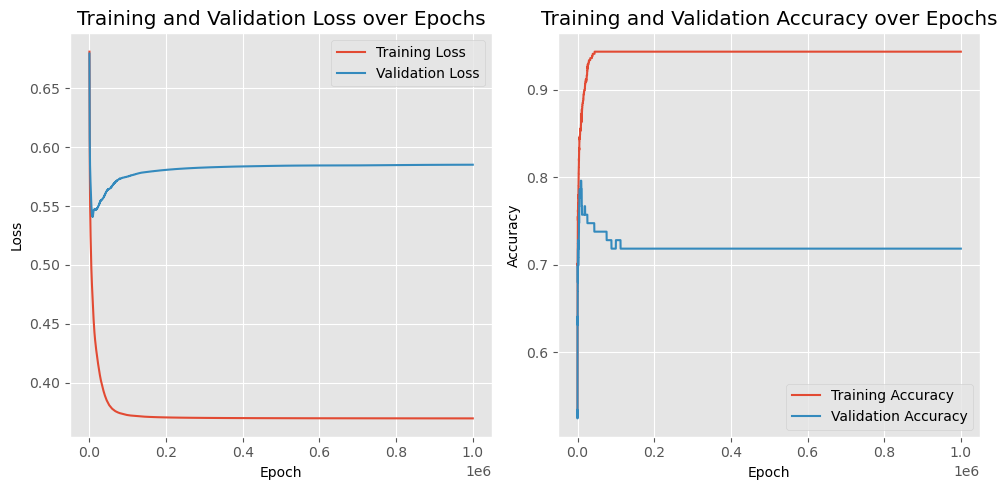

In [115]:
import matplotlib.pyplot as plt
epochs = range(1, len(losses) + 1)

# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
